In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set2')

In [2]:
def oracle(numbers, goal, wires, aux_wires):
    """
    Oracle:
      marks states where the sum of the selected numbers is equal to the goal.
      args:
        numbers: list of numbers to sum
        goal: the goal number
        wires: the wires to apply the oracle to
        aux_wires: the auxiliary wires to perform the computation, mind for overflow
        """
    
    def add_k_fourier(k, wires):
        for j in range(len(wires)):
            qml.RZ(k * np.pi / (2**j), wires=wires[j])

    def compute_sum_in_fourier_basis():
        qml.QFT(wires=aux_wires)
        for idx, wire in enumerate(wires):
            qml.ctrl(add_k_fourier, control=wire)(numbers[idx], wires=aux_wires)
        qml.adjoint(qml.QFT)(wires=aux_wires)
        
    compute_sum_in_fourier_basis()

    qml.FlipSign(goal, aux_wires) ## check
    
    qml.adjoint(compute_sum_in_fourier_basis)()

def grover_circuit(numbers, goal, rep):
    num_wires = len(numbers)
    aux_wires = [num_wires + i for i in range(num_wires)]
    dev = qml.device("default.qubit", wires=num_wires + num_wires)
    
    @qml.qnode(dev)
    def circuit():
        qml.Snapshot("init", measurement= qml.probs(wires=range(num_wires)))
        # Step 1: Apply Hadamard gates to all variable wires
        for wire in range(num_wires):
            qml.Hadamard(wires=wire)
        qml.Snapshot("init", measurement= qml.probs(wires=range(num_wires)))

        for i in range(rep):
            # Step 2: Apply the oracle
            oracle(numbers, goal, range(num_wires), aux_wires)
            qml.Snapshot(f"oracle_{i + 1}", measurement= qml.probs(wires=range(num_wires)))
            
            # Step 3: Apply Grover's diffusion operator
            qml.GroverOperator(wires=range(num_wires))
            qml.Snapshot(f"diffusion_{i + 1}", measurement= qml.probs(wires=range(num_wires)))
        
        return qml.probs(wires=range(num_wires))
    
    return circuit


<Figure size 1000x3000 with 0 Axes>

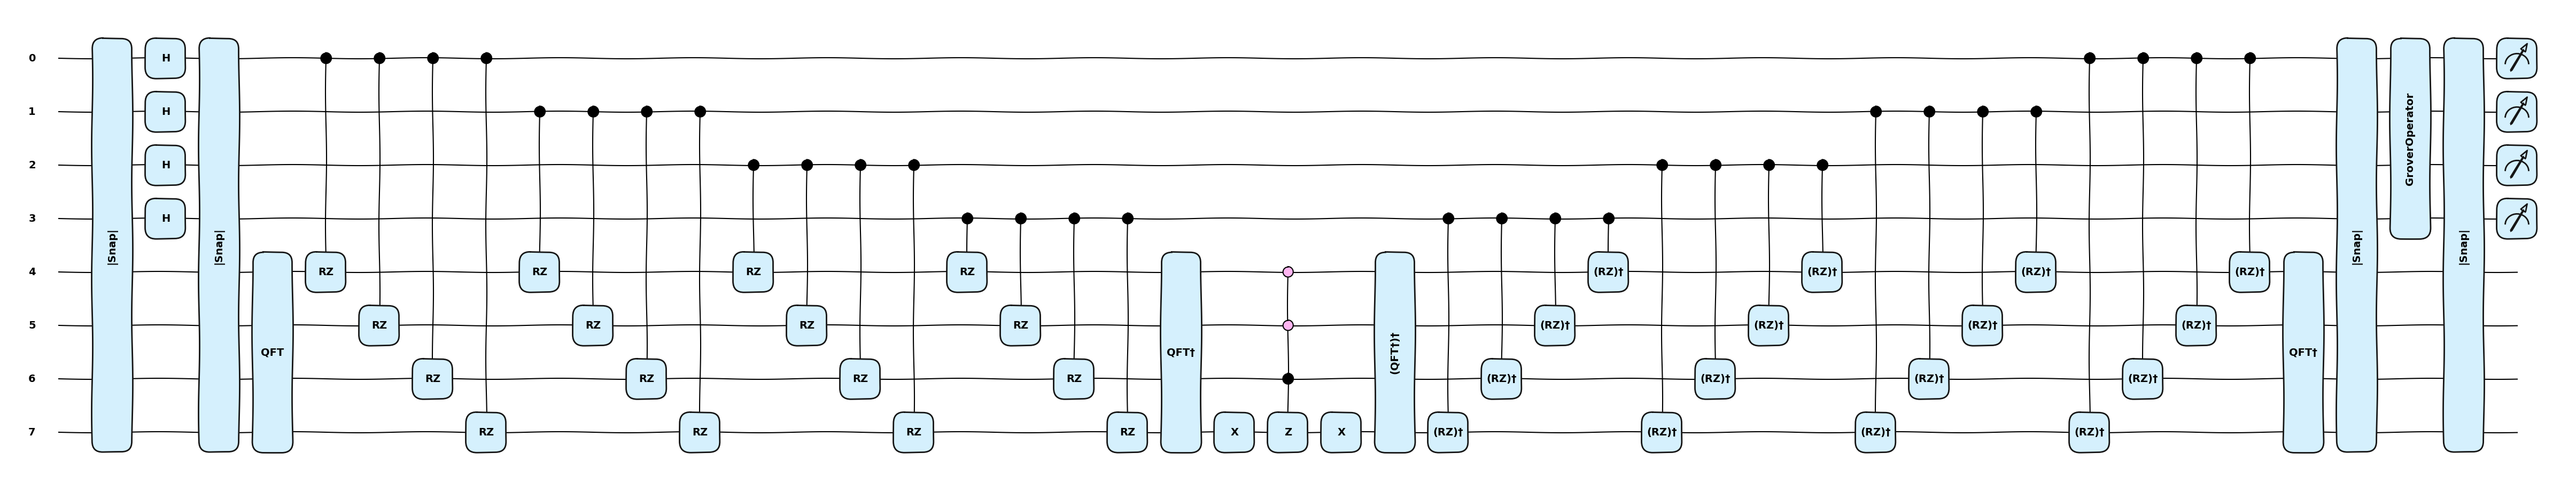

In [4]:
numbers = [1,1,1,2] 
goal = 2  # goal sum
rep = 1 # number of Grover iterations

# Get the circuit function
circuit = grover_circuit(numbers, goal, rep)

# Extract probabilities
result = circuit()

# Draw the circuit with all wires
plt.figure(figsize=(10, 30))
qml.draw_mpl(circuit, 
             show_all_wires=True, 
             style="pennylane_sketch",
             expansion_strategy="device")()
plt.show()


In [ ]:
plt.bar( range(len(result)),  result)

In [ ]:
numbers = [1,3,8,2]
goal = 5
circuit = grover_circuit(numbers, goal, 10)
snaps = qml.snapshots(circuit)()
prob_seq = [snaps[s].numpy() for s in snaps.keys()]
prob_seq_grover = [snaps[s].numpy() for s in snaps.keys() if "diffusion" in s]
qml.snapshots(circuit)().keys()

In [ ]:
## treshold to check if 2 numbers are equal
treshold = 10e-5
num_of_sol = np.sum(np.abs(prob_seq[2] - np.max(prob_seq[2])) < treshold) 
maxiter = len(prob_seq)
max_pos = np.argmax(prob_seq[2])
grover_steps_p = [i[max_pos] for i in prob_seq_grover]
all_p = [i[max_pos] for i in prob_seq]
plt.plot(range(0, len(grover_steps_p)), (np.array(grover_steps_p) * num_of_sol), marker='o', linestyle='--', label='solution probability')

In [ ]:
list(snaps.keys())

In [ ]:
import matplotlib.pyplot as plt

num_subplots = len(prob_seq)
rows = (num_subplots + 1) // 2 
fig, axs = plt.subplots(rows, 2, figsize=(14, rows * 4)) 
names = list(snaps.keys())

for i in range(num_subplots):
    row = i // 2
    col = i % 2
    axs[row, col].bar(range(len(prob_seq[i])), prob_seq[i])
    axs[row, col].set_title(names[i])
    axs[row, col].set_ylim([0, 1])

if num_subplots % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
numbers = [1,3,8,2]
goal = 5
reps = 30
circuit = grover_circuit(numbers, goal, reps)
snaps = qml.snapshots(circuit)()
prob_seq = [snaps[s].numpy() for s in snaps.keys()]
prob_seq_grover = [snaps[s].numpy() for s in snaps.keys() if "diffusion" in s]
treshold = 10e-5
num_of_sol = np.sum(np.abs(prob_seq[2] - np.max(prob_seq[2])) < treshold) 
maxiter = len(prob_seq)
max_pos = np.argmax(prob_seq[2])
grover_steps_p = [i[max_pos] for i in prob_seq_grover]
all_p = [i[max_pos] for i in prob_seq]

def parametrized_sine(x, amplitude, frequency, phase):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

# plot the behaviour of the probability for finding the (one of the) solution(s)
plt.plot(
    range(0, len(grover_steps_p)), 
    (np.array(grover_steps_p) * num_of_sol), 
    marker='o', 
    linestyle='--', 
    label='solution probability')

## plot sine as a reference
x = np.linspace(0, reps, 1000)
y = parametrized_sine(x, 0.5, 1/(2*np.pi), 0)
plt.plot(x, (y + 0.5), alpha=0.5)